## Прогнозирование оттока клиентов из банка.

## Введение

В банке увеличился отток клиентов. Так как удерживать действующих клиентов дешевле и выгоднее компании, чем привлекать новых, необходимо исследовать поведение клиентов и научиться прогнозировать возможный уход клиента из банка, чтобы своевременно принимать меры по удержанию. 
В нашем распоряжении данные 10 000 клиентов, часть из которых покинули банк, часть остались действующими.  

In [104]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import precision_recall_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [105]:
df = pd.read_csv('/datasets/Churn.csv')
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Колонки `rownumber` и `surname` удалим, так как они не помогут в исследовании. 
Колонки `geography` и `gender` необходимо преобразовать из категориальных в количетсвенные. Выполним эту операцию методом прямого кодирования с удалением первого столбца для избежания дамми-ловушки. 
Остальные колонки исследуем на предмет содержащихс данных. При необходимости выполним масштабирование.
Пропущенные значения в колонке `tenure` заполним медианными значениями. 

In [106]:
df = df.drop(columns = ['rownumber', 'surname', 'customerid'])

In [107]:
median_tenure = df['tenure'].median()
df['tenure'] = df['tenure'].fillna(np.random.randint(1,8+1))

Преобразуем категориальные колонки в количественные.

In [108]:
df_ohe = pd.get_dummies(df,drop_first=True)
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   numofproducts      10000 non-null  int64  
 5   hascrcard          10000 non-null  int64  
 6   isactivemember     10000 non-null  int64  
 7   estimatedsalary    10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [109]:
for c in df_ohe.columns:
    try:
        print (df_ohe[c].describe())
        print ('--------------')
    except:
        pass

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: creditscore, dtype: float64
--------------
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64
--------------
count    10000.000000
mean         4.725200
std          2.891422
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         10.000000
Name: tenure, dtype: float64
--------------
count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64
--------------
count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000

Разбросы значений в таблице неоднородны. Необходимо выполнить масштабирование признаков. 
Сначала разделим выборку на признаки и целевой показатель. 
Далее выполним стандартизацию признаков. После, разделим выборки на тренировочные, валидационные и тестовые, с сохранением дисбаланса классов. 

In [110]:
# Делим выбоорку на признаки
features = df_ohe.drop(columns =['exited'])
target = df_ohe['exited']



# Создаем тестовые, тренировочные и валидационные выборки
(features_train, 
 features_valid_test, 
 target_train, 
 target_valid_test) = train_test_split(features, target,
                                       test_size = 0.25, 
                                       random_state = 12345,
                                       stratify = target)
(features_test,
features_valid,
target_test,
target_valid) = train_test_split (features_valid_test, target_valid_test,
                                test_size = 0.5,
                                random_state = 12345, 
                                stratify = target_valid_test)


# Выполняем маcштабирование
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

features_train = pd.DataFrame(features_train_scaled, index = features_train.index, columns = features_train.columns)
features_valid = pd.DataFrame(features_valid_scaled, index = features_valid.index, columns = features_valid.columns)
features_test = pd.DataFrame(features_test_scaled, index = features_test.index, columns = features_test.columns)






print (features_train.shape)
print (features_valid.shape)
print (features_test.shape)
print (target_train.shape)
print (target_valid.shape)
print (target_test.shape)

(7500, 11)
(1250, 11)
(1250, 11)
(7500,)
(1250,)
(1250,)


Исследуем дисбаланс классов в выборках. 

In [112]:
target_train.value_counts()

0    5972
1    1528
Name: exited, dtype: int64

Отметим, что ушедших из банка клиентов меньше, чем не ушедших. Нам предстоит решить задачу классификации с дисбалансом классов. 

## Обучение модели без учета дисбаланса классов. 

In [113]:
model_regression = LogisticRegression(random_state = 12345, solver = 'liblinear')
model_regression.fit(features_train, target_train)
predicted_regression = model_regression.predict(features_valid)
print (f1_score(predicted_regression,target_valid)) 

0.332378223495702


In [114]:
model_tree = DecisionTreeClassifier(random_state = 12345)
model_tree.fit(features_train,target_train)
predicted_tree = model_tree.predict(features_valid)
print (f1_score(target_valid, predicted_tree))

0.48015122873345933


In [115]:
model_forest = RandomForestClassifier(random_state = 12345)
model_forest.fit(features_train, target_train)
predicted_forest = model_forest.predict (features_valid)
print (f1_score(predicted_forest, target_valid))

0.5638554216867471


Модель случайного леса выглядит наиболее интересной с точки зрения f1 метрики. Найдем для нее параметры `n_estimators`, `max_depth`.

In [116]:
best_f1 = 0
for n in range (100, 1000, 100):
    model_forest = RandomForestClassifier(random_state = 12345, max_depth = 6, n_estimators = n)
    model_forest.fit(features_train, target_train)
    predicted_values = model_forest.predict(features_valid)
    f1_current = f1_score(predicted_values, target_valid)
    if f1_current > best_f1:
        best_f1 = f1_current
print ('лучшая модель:', model_forest, 'значение f1:',best_f1)

лучшая модель: RandomForestClassifier(max_depth=6, n_estimators=900, random_state=12345) значение f1: 0.5298701298701298


In [117]:
best_f1 = 0
for d in range (5, 20):
    model_forest = RandomForestClassifier(random_state = 12345, max_depth = d, n_estimators = 300)
    model_forest.fit(features_train, target_train)
    predicted_values = model_forest.predict(features_valid)
    f1_current = f1_score(predicted_values, target_valid)
    if f1_current > best_f1:
        best_f1 = f1_current
print ('лучшая модель:', model_forest, 'значение f1:',best_f1)

лучшая модель: RandomForestClassifier(max_depth=19, n_estimators=300, random_state=12345) значение f1: 0.5734939759036145


Дообучим модель со значением параметров `max_depth` = 19, `n_estimators` = 1000 валидационной выборкой и посчитаем значение метрики f1 на тестовой выборке. 

In [118]:
%%time
final_model_forest = RandomForestClassifier(random_state = 12345, max_depth = 15, n_estimators = 1000)
final_model_forest.fit (features_train, target_train)
final_model_forest.fit (features_valid, target_valid)
predicted_values = final_model_forest.predict(features_test)
print (f1_score(predicted_values, target_test))

0.551558752997602
CPU times: user 6.92 s, sys: 22.9 ms, total: 6.94 s
Wall time: 6.94 s


### Выводы: 
Лучшее значение на обучающей выборке дает модель RandomForestClassifier со значением f1 метрики = 0.57
</p> Примем значения max_depth = 15, n_estimators = 1000. 
</p> На тестовой выборке значение f1 метрики составляет 0.53

</p> Далее, выполним обучение модели с учетом дисбаланса классов, методами upsampling, и изменением порога классов. 

## Увеличение классов (upsampling)

Ушедших клиентов меньше, чем клиентов, оставшихся с банком, поэтому увеличим выборку клиентов, ушедших из банка перед обучением моделей. 
Для увеличения выборки выполним последовательно следующие действия: 
1. Разделим выборки `features` и `target` по классам. 
2. Умножим получившиеся выборки класса '1' на три. 
3. Соединим получившиеся выборки в одну таблицу. 
4. Перемешаем строки. 
Далее, приступим к обучению модели. 

In [119]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0] # выделяем объекты с классом 0
    features_ones = features[target == 1] # с классов 1
    target_zeros = target[target == 0] # аналогично для датасета с таргетом
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + ([features_ones] * repeat)) # умножаем объекты класса 1 и соединяем датасеты
    target_upsampled = pd.concat([target_zeros] + ([target_ones] * repeat)) # аналогично для таргета

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345) # перемешиваем объекты

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Найдем оптимальную модель из случайного леса, дерева принятия решений, логистической регрессии.

In [120]:
%%time
sh_model_forest = RandomForestClassifier(random_state = 12345)
sh_model_forest.fit(features_upsampled, target_upsampled)
predicted_values = sh_model_forest.predict(features_valid)
print (f1_score(target_valid, predicted_values))

0.5887445887445888
CPU times: user 850 ms, sys: 1.94 ms, total: 852 ms
Wall time: 851 ms


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправил. 
</div>

In [121]:
%%time
sh_model_regression = LogisticRegression(random_state = 12345)
sh_model_regression.fit(features_upsampled, target_upsampled)
predicted_values = sh_model_regression.predict(features_valid)
print (f1_score(target_valid, predicted_values))

0.48087431693989074
CPU times: user 18.8 ms, sys: 35.1 ms, total: 54 ms
Wall time: 12.3 ms


In [122]:
%%time
sh_model_tree = DecisionTreeClassifier(random_state = 12345)
sh_model_tree.fit(features_upsampled, target_upsampled)
predicted_values = sh_model_tree.predict(features_valid)
print (f1_score(target_valid, predicted_values))

0.49108910891089114
CPU times: user 58 ms, sys: 133 ms, total: 191 ms
Wall time: 37.9 ms


Лучшие результаты на увеличенной выборке дает модель LogisticRegression. Выполним подбор гиперпараметров.

In [123]:
best_f1 = 0
for i in range (100, 1001, 100):
        model = LogisticRegression(random_state= 12345, max_iter = i, solver = 'liblinear')
        model.fit (features_upsampled, target_upsampled)
        predicted_values = model.predict(features_valid)
        f1_current = f1_score(predicted_values, target_valid)
        if f1_current > best_f1:
            best_iter = i
            best_f1 = f1_current
            best_model = model
print (best_f1, best_model, best_iter)

0.48087431693989074 LogisticRegression(random_state=12345, solver='liblinear') 100


In [124]:
predicted_test = best_model.predict(features_test)
print (f1_score(predicted_test, target_test))

0.5243243243243244


### Выводы: 
Лучшее значение f1 метрики получено на модели `LogisticRegression`, но полученное значение меньше, чем значение, полученное при обучении без учета дисбаланса классов. 
Далее, обучим модель с балансировкой классов. 

## Балансировка классов. 

Выполним балансировку классов для каждой, из выбранных моделей. 
Найдем оптимальные гиперпараметры и проверим значение f1 метрики лучшей модели на тестовой выборке.

In [125]:
model_balanced_regression = LogisticRegression(random_state=12345,class_weight='balanced')
model_balanced_regression.fit(features_train, target_train)
predicted_values = model_balanced_regression.predict(features_valid)
print (f1_score(predicted_values, target_valid))

0.4835164835164835


In [126]:
model_balanced_tree = DecisionTreeClassifier(random_state = 12345, class_weight='balanced')
model_balanced_tree.fit(features_train, target_train)
predicted_values = model_balanced_tree.predict(features_valid)
print (f1_score(predicted_values, target_valid))

0.49603174603174605


In [127]:
model_balanced_forest = RandomForestClassifier(random_state = 12345, class_weight='balanced')
model_balanced_forest.fit(features_train, target_train)
predicted_values = model_balanced_forest.predict(features_valid)
print (f1_score(predicted_values, target_valid))

0.5552825552825552


Модель случайного леса дает наилучший результат f1 метрики. Найдем оптимальные гипер-параметры.

In [128]:
best_balanced_f1 = 0

for d in range(3,10,1):
    for e in range (100, 1001, 100):
        model_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced',
                                                     max_depth = d, n_estimators = e)
        model_balanced.fit(features_train, target_train)
        predicted_values = model_balanced.predict(features_valid)
        f1_current = (f1_score(target_valid, predicted_values))
        if f1_current>best_balanced_f1:
            best_balanced_f1 = f1_current
            best_model = model_balanced
print (best_balanced_f1, best_model)     

0.6317689530685922 RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=800,
                       random_state=12345)


In [129]:
predicted_values = best_model.predict(features_test)
print (f1_score(predicted_values, target_test))

0.6593406593406593


### Выводы:
Значение f1 метрики при балансировке классов составляет 0.65!

## Обучение с изменением порога классов.

1. Обучим модель, с гиперпараметрами, наиболее дающими лучший f1_score с учетом дисбаланса классов.
2. Посчитаем вероятности классов. 
3. В цикле переберем возможные веса классов и надем оптимальный баланс для увеличения f1 метрики. 
4. Проверим получившеюся модель на тестовой выборке. 

Best Threshold=0.221480, G-Mean=0.784


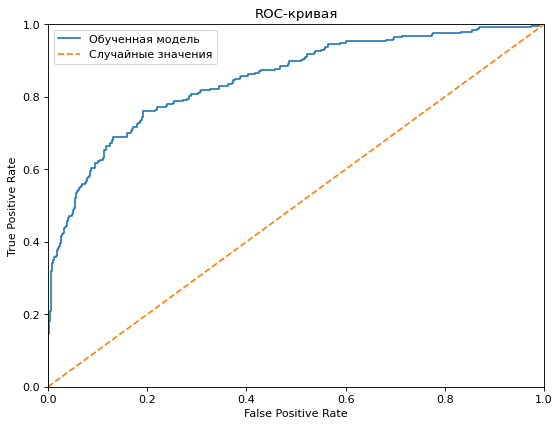

Best Threshold=0.306671, f1=0.627


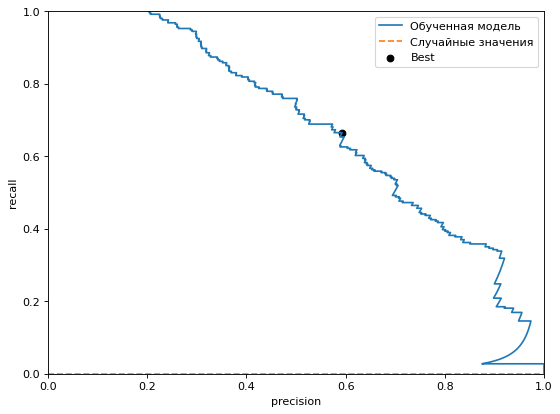

In [130]:
best_f1 = 0
best_treshold = 0
gmean = 0

dis_model = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators = 1000)
dis_model.fit(features_train, target_train)
predicted_ones = dis_model.predict_proba(features_valid)[:,1]


fpr,tpr,threshold = roc_curve(target_valid, predicted_ones)
gmeans = (tpr * (1-fpr))**0.5
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr, tpr, label='Обученная модель')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Случайные значения')
plt.legend()
plt.show()


precision, recall, thresholds = precision_recall_curve(target_valid, predicted_ones)
f1scores = (2 * precision * recall)/(precision + recall)
iy = np.argmax(f1scores)
print('Best Threshold=%f, f1=%.3f' % (thresholds[iy], f1scores[iy]))
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(precision, recall, label='Обученная модель')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('precision')
plt.ylabel('recall')
plt.plot([0,1], [0,0], linestyle='--', label='Случайные значения')
plt.scatter(precision[iy], recall[iy], marker='o', color='black', label='Best')
plt.legend()
plt.show()

Выберем значение порога = 0.374 и проверим модель на тестовой выборке. 

In [131]:
predicted_ones = dis_model.predict_proba(features_test)[:,1]
predicted_values = predicted_ones>0.29
f1 = f1_score(predicted_values, target_test)
auc_roc = roc_auc_score(target_test, predicted_ones)
print ('f1 =',f1)
print ('auc_roc =', auc_roc)
print ('accuracy_score =', accuracy_score(target_test, predicted_values))

f1 = 0.6386861313868614
auc_roc = 0.8836969159523107
accuracy_score = 0.8416


На тестовых данных обученная модель показала значения метрики f1 = 0.625, auc_roc = 0.883. 
Далее проверим модель на вменяемость с помощью.

## Проверка на вменяемость

In [132]:
dummy_model = DummyClassifier(random_state = 12345, strategy='prior')
dummy_model.fit(features_train, target_train)
dummy_model.fit(features_valid, target_valid)
predicted_dummy = dummy_model.predict(features_test)
print ('f1 =', f1_score(target_test, predicted_dummy))
print ('accuracy_score =', accuracy_score(target_test, predicted_dummy))

f1 = 0.0
accuracy_score = 0.796


Тест на вменяемость модели пройден. Принимаем модель `RandomForestClassifier`со значением гиперпараметров max_depth = 15, n_estimators = 1000, и порогом классификации = 0.37 

## Вывод

### Предобработка данных
В датасете представлены данные по 10 000 клиентам, 25% из которых ушли из банка.
По 10% клиентов не были заполнены данные в колонке `tenure`, количество лет в качестве клиента. Пропущенные значения были заполнены медианными. 
Далее, были последовательно выполены шаги: 
1. Нормализация данных, так как в количественных данных был виден значительный разброс, что могло привести к нерелевантным результатам обучения из-за присвоения бОльшего веса классам с относительно большими значениями. 
2. Перевод категориальных признаков и количетсвенные методом прямого кодирования с удалением первого столбца для избежания dummy ловушек. 
3. Разделение датафрейма на тестовую, валидационную и обучающую выборки в пропорциях 3:1:1, с сохранением дисбаланса классов в каждой из выборок. 

### Работа с данными
1. Обчуение без учета дисбаланса классов. Из рассмотренных моделей, наиболее эффективной оказалась RandomForestClassifier, на которой удалось добиться значения f1 метрики 0.53 на тестовой выборке. 
2. Увеличение выборки. При увеличении выборки методом upsampling значение f1 метрики снизилось до 0.44 на тестовой выборке с самой эффективной моделью - DecisionTreeClassifier
3. Изменение порога классов. Наиболее эффективная, с учетом выбранной модели и оттталкиваясь от метрик precision и recall,  вероятность класса "1" составляет 0.37. При данном значении порога, значение метики f1 на тестовой выборке составило 0.625. 
4. Изменение баланса классов. При выборе значения гиперпараметра class_weight = 'balanced', удалось поднять значение метрики f1 до 0.65
